In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9833f1c35b2e5c172ee19dd63e4a089ac4068bfb1916267e52ea12d71124c44a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime.lime_tabular
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer

In [4]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [5]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## KNN Model


KNN Evaluation
Accuracy: 0.90
Precision: 0.89
Recall: 0.93
F1 Score: 0.91
AUC: 0.90
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       544
           1       0.89      0.93      0.91       635

    accuracy                           0.90      1179
   macro avg       0.91      0.90      0.90      1179
weighted avg       0.90      0.90      0.90      1179



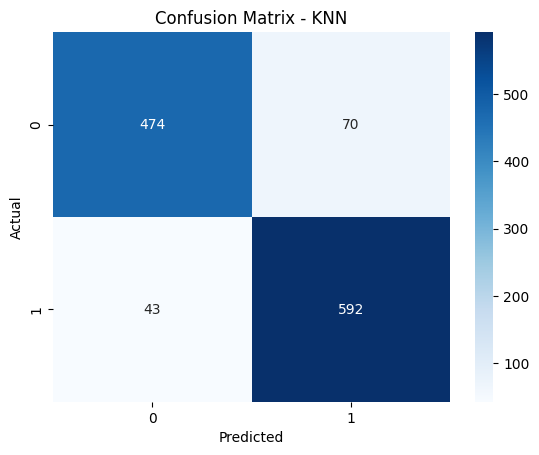

In [6]:
knn_final = KNeighborsClassifier(n_neighbors=15)
knn_final.fit(X_train_final, y_train)
evaluate_model("KNN", knn_final, X_test_final, y_test)

### LIME for KNN

In [8]:
sample_instance = X_test_final.iloc[0]

explainer = LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)

In [9]:
print("\nLIME Explanation for KNN")
exp = explainer.explain_instance(sample_instance.values, knn_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for KNN


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


This LIME explanation gives a local interpretation of one churn prediction:

* Churn Probability: The model predicts an 80% chance of churn.

* Top contributors to churn:

    * TotalCharges ≤ 247.16: Low total charges indicate the customer is relatively new.

    * tenure ≤ 4: Very short tenure strengthens the churn signal.

    * Negative discount_score: Suggests the customer isn’t receiving a competitive price.

    * High MonthlyCostPerTenure: Paying a lot early in the relationship contributes to churn.

* Features against churn:

    * Features like using a credit card for payment, being male, and being in a family package appear to slightly reduce churn, but with minimal impact here.

This customer is flagged as high-risk due to low tenure, low total charges, and unfavorable pricing—classic early-stage churn indicators.

### PDP for KNN

In [10]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_final.columns.tolist().index(selected_feature)


PDP - KNN


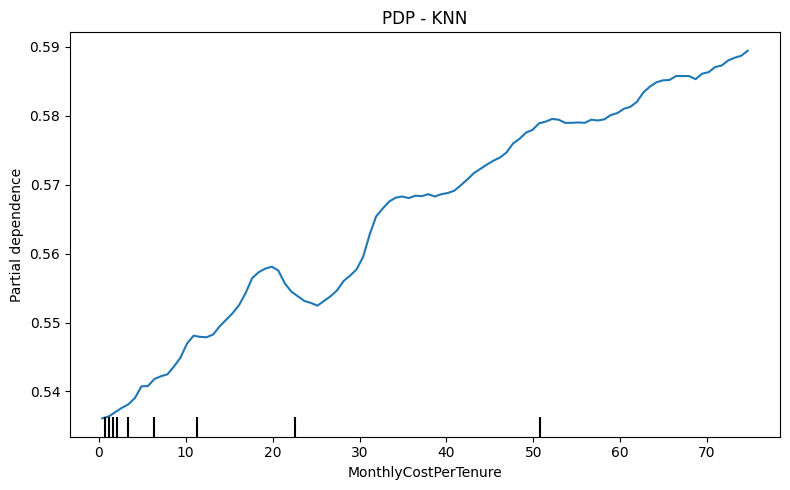

In [11]:
print("\nPDP - KNN")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(knn_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - KNN")
plt.tight_layout()
plt.show()

This PDP shows the relationship between MonthlyCostPerTenure and the predicted churn probability across all customers.

Overall Trend: As MonthlyCostPerTenure increases, churn probability gradually rises.

Interpretation: Customers who pay more per unit of tenure are more likely to churn.

Model Behavior: The plot is relatively smooth, though KNN typically shows more fluctuation—indicating moderate sensitivity to this feature.

This confirms that KNN associates higher cost per tenure with increased churn risk, although the effect is more gradual compared to tree-based models.

### ICE for KNN

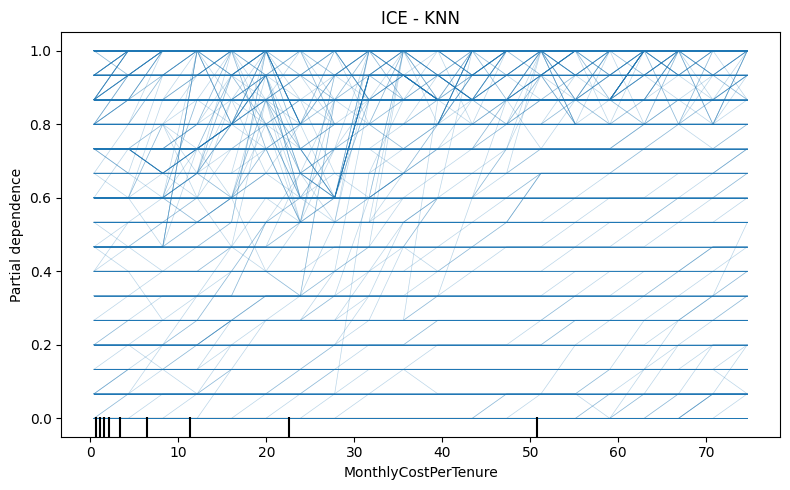

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(knn_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - KNN")
plt.tight_layout()
plt.show()

This ICE plot for the KNN model shows how MonthlyCostPerTenure affects churn prediction for individual customers.

Flat Lines: Most lines are flat or have sudden jumps, indicating that predictions change abruptly for some customers, but remain constant for others.

Discontinuous Behavior: This pattern is expected in KNN, which makes decisions based on discrete neighbor sets rather than smooth trends.

High Churn Zones: Many customers have predictions close to 1.0 (high churn), regardless of MonthlyCostPerTenure, especially at higher values.

The ICE plot shows that KNN’s churn predictions can be abrupt and vary sharply per customer, with limited smooth responsiveness to changes in MonthlyCostPerTenure.

## Neural Network Model


Neural Network Evaluation
Accuracy: 0.89
Precision: 0.85
Recall: 0.98
F1 Score: 0.91
AUC: 0.89
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.87       544
           1       0.85      0.98      0.91       635

    accuracy                           0.89      1179
   macro avg       0.91      0.89      0.89      1179
weighted avg       0.90      0.89      0.89      1179



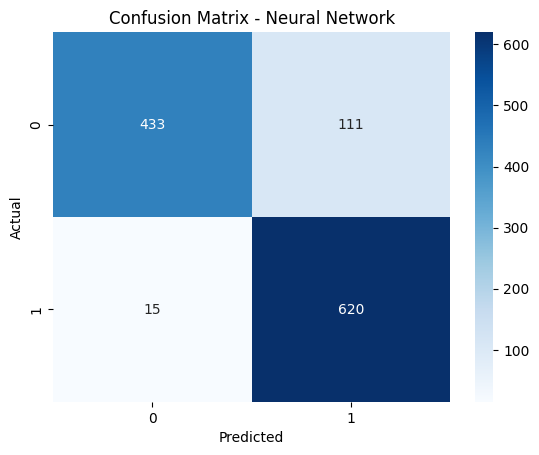

In [13]:
nn_final = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42)
nn_final.fit(X_train_final, y_train)
evaluate_model("Neural Network", nn_final, X_test_final, y_test)

### LIME for NN

In [14]:
print("\nLIME Explanation for Neural Network (MLP)")
exp = explainer.explain_instance(sample_instance.values, nn_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for Neural Network (MLP)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Predicted churn probability = 93%.

The model strongly believes the customer will churn.

Key contributors toward churn:

* Low TotalCharges (≤ 247.16) → strongest indicator of churn (0.34).

* Low discount_score → they’re not receiving a price benefit.

* High MonthlyCostPerTenure → paying more in a shorter time.

* Paperless billing + short contract patterns (implied by other features).

Key contributors against churn:
* Features like OnlineSecurity_Yes = 0, OnlineBackup_No = 1, and StreamingMovies_Yes = 0 help reduce churn risk slightly — but not enough to outweigh the stronger churn signals.

This customer is flagged as high risk of churn due to paying high costs early (MonthlyCostPerTenure, TotalCharges), not receiving discounts, and lacking certain support features.

### PDP for NN


PDP - MLP


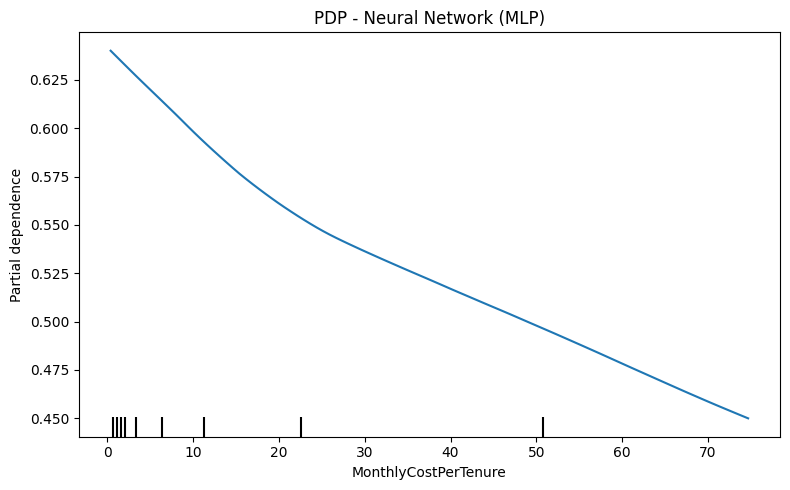

In [15]:
print("\nPDP - MLP")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(nn_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - Neural Network (MLP)")
plt.tight_layout()
plt.show()

This PDP for the Neural Network (MLP) model shows how MonthlyCostPerTenure affects the average predicted churn probability.

Negative Relationship (0–25): As MonthlyCostPerTenure increases from low values up to ~25, churn probability decreases. This suggests that customers paying moderately more relative to their tenure might be more committed.

Flattening Trend (>25): After ~25, the curve levels off and slightly increases, indicating that higher values of MonthlyCostPerTenure have minimal additional effect or may slightly raise churn risk.

The MLP model learns a nonlinear relationship where churn risk drops initially with increased cost-per-tenure, but the effect plateaus later. This reflects a stabilization in the model’s perception of churn likelihood at higher cost levels.








### ICE for NN

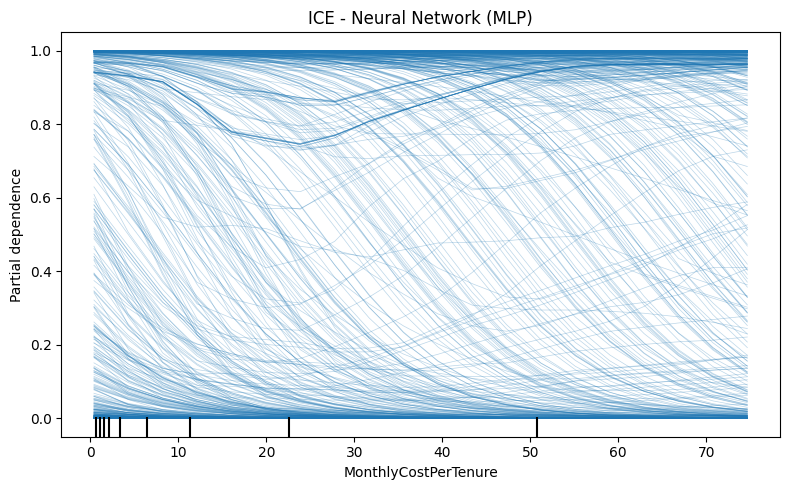

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(nn_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - Neural Network (MLP)")
plt.tight_layout()
plt.show()

This ICE plot shows how MonthlyCostPerTenure influences churn predictions for individual customers.

Many lines start high and decrease: For several customers, increasing MonthlyCostPerTenure reduces churn probability — possibly indicating that early high-cost users are seen as more committed.

Some lines remain flat: These customers' churn predictions are insensitive to changes in this feature — suggesting other features dominate for them.

Others slightly increase: A few lines trend upward, implying higher cost-per-tenure increases churn risk for those customers.

The ICE plot reveals customer-specific variability in how MonthlyCostPerTenure affects churn. The MLP model shows a nonlinear and heterogeneous response, aligning with the smoother global trend seen in the PDP.